In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn

D:\Users\tommy\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Data Dimension
num_input = 28# MNIST data input (image  shape: 28x28) 
timesteps = 28 # Timesteps
n_classes = 10# Number of classes, one class per digit 
num_hidden_units = 128 # Number of hidden units of the RNN 

In [3]:
def load_data(mode='train'):
    """
    Function to (download and) load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets (" MNIST_data/", one_hot=True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                            mnist.validation.images, mnist.validation.labels
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
    return x_test, y_test
                                   
def randomize(x, y):
    """" Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y. shape [0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y
                                   
def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [4]:
x_train, y_train, x_valid, y_valid = load_data(mode='train')
print("Size of:")
print("- Training-set:\t\t{}".format(len(y_train)))
print("- Validation-set:\t{}".format(len(y_valid)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting  MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting  MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting  MNIST_data/t10k-images-idx3-ubyte.gz
Extracting  MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Size of:
- Training-set:		55000
- Validation-set:	5000


In [5]:
learning_rate = 0.001# The optimization initial Learning rate
epochs = 10 #Total number of training epochs 
batch_size = 100# Training batch size
display_freq=100 # Frequency of displaying the training  results 

In [6]:
# weight and bais wrappers
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('w',
                            dtype=tf.float32,
                            shape=shape,
                            initializer=initer)

def bias_variable(shape):
    """"
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                            dtype=tf.float32,
                            initializer=initial)

In [7]:
def RNN(x, weights, biases, timesteps, num_hidden):
    # Prepare data shape to match "rnn" function requirements
    # Current data  input shape:  (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors List of shape (batch_size, n_input)
    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)
    # Define a rnn cell with tensorflow
    rnn_cell = rnn.BasicRNNCell(num_hidden)
    # Get lstm cell output
    # If no initial_state is provided, dtype must be  specified
    # If no initial cell state is provided, they will be initialized to zerd
    states_series, current_state = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    # Linear activation, using rnn  inner Loop Last output
    return tf.matmul(current_state, weights) + biases

In [8]:
# PLaceholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, timesteps, num_input], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

In [9]:
# create weight matrix initialized randomely from N~(0, 0.01)
W = weight_variable(shape=[num_hidden_units, n_classes])

# create bias vector initialized as zero   
b = bias_variable(shape=[n_classes])
                         
output_logits = RNN(x, W, b, timesteps, num_hidden_units)
y_pred = tf.nn.softmax(output_logits)

In [10]:
# Model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')
                           
# Define the Loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate, name= 'Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name= 'accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
# Creating the op for initializing all variables
init = tf.global_variables_initializer()

In [12]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch:{}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        global_step +=1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)
        x_batch = x_batch.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)
        
        if iteration % display_freq == 0:
            # Calculate  and display the batch Loss and accuracy
            loss_batch, acc_batch =  sess.run([loss, accuracy],
                                                feed_dict=feed_dict_batch)
            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                format(iteration, loss_batch, acc_batch))
                   
# Run validation after every epoch
                   
feed_dict_valid = {x: x_valid[:1000].reshape((-1, timesteps, num_input)), y: y_valid[:1000]}
loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
print('----------------------------------')
print("Epoch:  (0), validation loss: {1:.2f}, validation accuracy: {2:.01%}".
        format(epoch + 1, loss_valid, acc_valid))
print('----------------------------------')

Training epoch:1
iter   0:	 Loss=2.28,	Training Accuracy=23.0%
iter 100:	 Loss=0.82,	Training Accuracy=73.0%
iter 200:	 Loss=0.57,	Training Accuracy=86.0%
iter 300:	 Loss=0.51,	Training Accuracy=84.0%
iter 400:	 Loss=0.42,	Training Accuracy=86.0%
iter 500:	 Loss=0.22,	Training Accuracy=95.0%
Training epoch:2
iter   0:	 Loss=0.22,	Training Accuracy=92.0%
iter 100:	 Loss=0.24,	Training Accuracy=94.0%
iter 200:	 Loss=0.64,	Training Accuracy=85.0%
iter 300:	 Loss=0.38,	Training Accuracy=90.0%
iter 400:	 Loss=0.21,	Training Accuracy=92.0%
iter 500:	 Loss=0.30,	Training Accuracy=89.0%
Training epoch:3
iter   0:	 Loss=0.26,	Training Accuracy=93.0%
iter 100:	 Loss=0.22,	Training Accuracy=93.0%
iter 200:	 Loss=0.32,	Training Accuracy=91.0%
iter 300:	 Loss=0.16,	Training Accuracy=94.0%
iter 400:	 Loss=0.26,	Training Accuracy=95.0%
iter 500:	 Loss=0.10,	Training Accuracy=98.0%
Training epoch:4
iter   0:	 Loss=0.11,	Training Accuracy=96.0%
iter 100:	 Loss=0.18,	Training Accuracy=95.0%
iter 200:	 L

In [13]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
     :param images: array of images to be plotted, (9, img_h*img_w)
     :param cls_true: corresponding true labels (9,)
     :param cls_pred: corresponding true labels (9,)
      """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
    # Plot image.
        ax.imshow(np.squeeze(images[i]).reshape(28, 28), cmap='binary')
    # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}" .format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}" .format(cls_true[i], cls_pred[i])
        ax.set_title(ax_title)
                 # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks ([])
    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)
def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """          

    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))
    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]
    # Get the true and predicted classes for those images.
    cls_pred =cls_pred[incorrect]
    cls_true =cls_true[incorrect]
    # Plot the first g images.
    plot_images(images=incorrect_images [0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

Extracting  MNIST_data/train-images-idx3-ubyte.gz
Extracting  MNIST_data/train-labels-idx1-ubyte.gz
Extracting  MNIST_data/t10k-images-idx3-ubyte.gz
Extracting  MNIST_data/t10k-labels-idx1-ubyte.gz
-----------------------------------
Test loss: 0.14, test accuracy:  95.6%
-----------------------------------


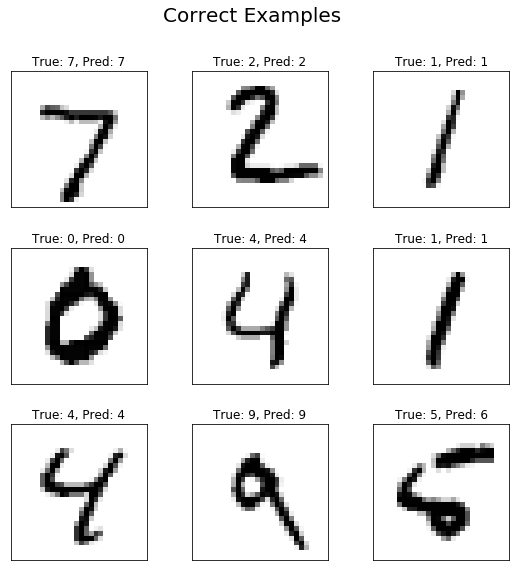

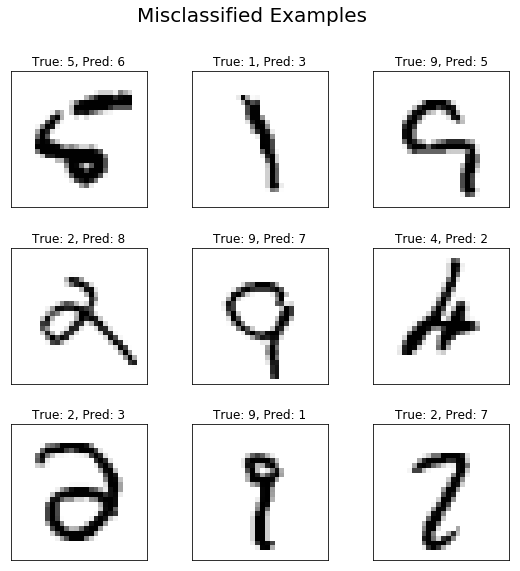

In [14]:
x_test, y_test = load_data(mode='test')
feed_dict_test = {x: x_test[:1000].reshape((-1, timesteps, num_input)), y: y_test[:1000]}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('-----------------------------------')
print("Test loss: {0:.2f}, test accuracy:  {1:.01%}" .format(loss_test, acc_test))
print('-----------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test, axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000],cls_true[:1000], cls_pred, title='Misclassified Examples')
plt.show()

In [15]:
def single_layer_static_lstm(input_x, n_steps, n_hidden):
    input_x1 = tf.unstack(input_x, num=n_steps, axis=1)
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, forget_bias=1.0)
    hiddens, states = tf.contrib.rnn.static_rnn(cell=lstm_cell, inputs=input_x1, dtype=tf.float32)
    return hiddens,states

In [16]:
def single_layer_static_gru(input_x, n_steps, n_hidden):
    input_x1 = tf.unstack(input_x, num=n_steps, axis=1)
    gru_cell = tf.contrib.rnn.GRUCell(num_units=n_hidden)
    hiddens,states = tf.contrib.rnn.static_rnn(cell=gru_cell, inputs=input_x1, dtype=tf.float32)
    return hiddens,states

In [17]:
def single_layer_dynamic_lstm(input_x, n_steps, n_hidden):
    lstm_cell = tf.contrib.rnn.BasicLSTMCell (num_units=n_hidden, forget_bias=1.0)
    hiddens, states = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=input_x, dtype=tf.float32)
    hiddens = tf.transpose(hiddens,[1,0,2])
    return hiddens,states

In [18]:
def single_layer_dynamic_gru(input_x, n_steps, n_hidden):
    gru_cell = tf.contrib.rnn.GRUCell (num_units=n_hidden)
    hiddens, states = tf.nn.dynamic_rnn(cell=gru_cell, inputs=input_x, dtype=tf.float32)
    hiddens = tf.transpose(hiddens,[1,0,2])
    return hiddens,states

In [19]:
def multi_layer_static_lstm(input_x,n_steps,n_hidden):
    input_x1 = tf.unstack(input_x,num=n_steps,axis=1)
    stacked_rnn = []
    for i in range(3):
        stacked_rnn.append(tf. contrib.rnn.LSTMCell(num_units=n_hidden))
    mcell = tf.contrib.rnn.MultiRNNCell(cells=stacked_rnn)
    hiddens, states = tf.contrib.rnn.static_rnn(cell=mcell,inputs=input_x1,dtype=tf.float32)
    return hiddens, states

In [20]:
def multi_layer_static_gru(input_x,n_steps,n_hidden):
    input_x1 = tf.unstack(input_x,num=n_steps,axis=1)
    stacked_rnn = []
    for i in range(3):
        stacked_rnn.append(tf.contrib.rnn.GRUCell(num_units=n_hidden))
    mcell = tf.contrib.rnn.MultiRNNCell(cells=stacked_rnn)
    hiddens,states = tf.contrib.rnn.static_rnn(cell=mcell,inputs=input_x1,dtype=tf.float32)
    return hiddens, states

In [37]:
def multi_layer_static_mix(input_x,n_steps,n_hidden):
    input_x1 = tf.unstack(input_x,num=n_steps,axis=1)
    gru_cell = tf.contrib.rnn.GRUCell (num_units=n_hidden*2)
    stm_cell = tf.contrib.rnn.LSTMCell (num_units=n_hidden)
    mcell = tf.contrib.rnn.MultiRNNCell(cells=[lstm_cell,gru_cell])
    hiddens,states = tf.contrib.rnn.static_rnn(cell=mcell,inputs=input_x1,dtype=tf.float32)
    return hiddens, states

In [40]:
def multi_layer_dynamic_lstm(input_x,n_steps,n_hidden):
    stacked_rnn = []
    for i in range(3):
        stacked_rnn.append(tf.contrib.rnn. LSTMCell (num_units=n_hidden))
    mcell = tf.contrib.rnn.MultiRNNCell(cells=stacked_rnn)
    hiddens,states = tf.nn.dynamic_rnn(cell=mcell, inputs=input_x,dtype=tf.float32)
    hiddens = tf.transpose(hiddens,[1,0,2])
    return hiddens, states

In [23]:
def multi_layer_dynamic_gru(input_x,n_steps,n_hidden):
    stacked_rnn = []
    for i in range(3):
        stacked_rnn.append(tf.contrib.rnn.GRUCell(num_units=n_hidden))
    mcell = tf.contrib.rnn.MultiRNNCell(cells=stacked_rnn)
    hiddens,states = tf.nn.dynamic_rnn(cell=mcell, inputs=input_x,dtype=tf .float32)
    hiddens = tf.transpose(hiddens,[1,0,2])
    return hiddens, states

In [53]:
def multi_layer_dynamic_mix(input_x,n_steps,n_hidden):
    gru_cell = tf.contrib.rnn.GRUCell(num_units=n_hidden*2)
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_hidden)
    mcell = tf.contrib.rnn.MultiRNNCell(cells=[lstm_cell,gru_cell])
    hiddens, states = tf.nn.dynamic_rnn(cell=mcell, inputs=input_x,dtype=tf.float32)
    hiddens = tf.transpose(hiddens,[1,0,2])
    return hiddens, states

In [75]:
def single_layer_static_bi_lstm(input_x,n_steps,n_hidden):
    input_x1= tf.unstack(input_x,num=n_steps, axis=1)
    lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell (num_units=n_hidden, forget_bias = 1.0) 
    lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell (num_units=n_hidden, forget_bias = 1.0) 
    hiddens,fw_state,bw_state = tf.contrib.rnn.static_bidirectional_rnn(cell_fw=lstm_fw_cell,cell_bw=lstm_bw_cell,
                                                                        inputs=input_x1,dtype=tf.float32)
    print(' hiddens: In', type (hiddens), len(hiddens),hiddens [1].shape, hiddens[1].shape)
    return hiddens,fw_state,bw_state

In [79]:
def single_layer_dynamic_bi_lstm(input_x,n_steps,n_hidden):
    lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell (num_units=n_hidden, forget_bias = 1.0)
    lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell (num_units=n_hidden, forget_bias = 1.0)
    hiddens,state= tf.nn.bidirectional_dynamic_rnn(cell_fw=lstm_fw_cell,cell_bw=lstm_bw_cell,
                                                   inputs=input_x,dtype=tf.float32)
    print(' hiddens:\ n',type(hiddens), len(hiddens),hiddens[0].shape,hiddens[1].shape)
    hiddens=tf.concat(hiddens, axis=2) 
    hiddens=tf.transpose(hiddens, [1,0,2])
    return hiddens,state

In [72]:
def multi_layer_static_bi_lstm(input_x,n_steps,n_hidden):
    input_x1=tf.unstack(input_x, num=n_steps,axis=1)
    stacked_fw_rnn = []
    stacked_bw_rnn = []
    for i in range(3):
        stacked_fw_rnn.append(tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, forget_bias=1.0))
        stacked_bw_rnn.append(tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, forget_bias=1.0))
    hiddens,fw_state,bw_state =tf.contrib.rnn.stack_bidirectional_rnn(stacked_fw_rnn,stacked_bw_rnn,
                                                                        inputs=input_x1,dtype=tf.float32)
    print( 'hiddens:\n',type(hiddens),len(hiddens),hiddens[0].shape,hiddens[1].shape)
    return hiddens,fw_state,bw_state

In [85]:
def multi_layer_dynamic_bi_lstm(input_x,n_steps,n_hidden):
    stacked_fw_rnn = []
    stacked_bw_rnn = []
    for i in range(3):
        stacked_fw_rnn.append(tf.contrib.rnn.BasicLSTMCell (num_units=n_hidden, forget_bias = 1.0))
        stacked_bw_rnn.append(tf.contrib.rnn.BasicLSTMCell (num_units=n_hidden, forget_bias = 1.0))
    tf.contrib.rnn.MultiRNNCell
    hiddens,fw_state,bw_state = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(stacked_fw_rnn, stacked_bw_rnn,
                                                                               inputs=input_x,dtype=tf.float32)
    print(' hiddens: \n' , type (hiddens), hiddens.shape)
    hiddens = tf.transpose(hiddens, [1,0,2])
    return hiddens,fw_state,bw_state

In [51]:
def mnist_rnn_classfication(flag):
    '''
    1.導入數據集
    '''
    tf.reset_default_graph()
    from tensorflow.examples.tutorials.mnist import input_data
    

    mnist = input_data.read_data_sets('MNIST-data',one_hot=True)

    print (type(mnist)) #iclass  'tensorfLow. contrib. Learn.python. Learn.datasets. base. Datasets'x
    print('Training data shape: ' ,mnist.train.images.shape) #Training data shape: (55000,784)
    print( 'Test data shape: ',mnist.test.images.shape) #Test data shape: (10000, )784)
    print( 'Validation data shape:',mnist.validation.images.shape) #Validation  data shape: (5000,)784)
    print( 'Training label shape: ',mnist.train.labels.shape)
    '''
    2 定義參數與網路結構
    '''
    n_input = 28
    n_steps = 28
    n_hidden = 128
    n_classes = 10
    batch_size = 128
    training_step = 5000
    display_step = 200
    learning_rate =1e-4
    
    
    
    
    
    
    
    
    input_x=tf.placeholder(dtype=tf.float32,shape=[None,n_steps,n_input])
    input_y=tf.placeholder(dtype=tf.float32,shape=[None,n_classes])
    
    if flag == 1:
        print('單層靜態LSTM網路:')
        hiddens, states = single_layer_static_lstm(input_x,n_steps,n_hidden)
    elif flag == 2:
        print('單層靜態 gru 網路:')
        hiddens, states = single_layer_static_gru(input_x,n_steps,n_hidden)
    elif flag == 3:
        print('單層動態 LSTM 網路:')
        hiddens, states = single_layer_dynamic_lstm(input_x,n_steps,n_hidden)
    elif flag == 4:
        print('單層動態 gru 網路:')
        hiddens, states = single_layer_dynamic_gru(input_x,n_steps,n_hidden)
    elif flag == 5:
        print ('多層靜態 LSTM 網路:')
        hiddens, states = multi_layer_static_lstm(input_x,n_steps,n_hidden)
    elif flag == 6:
        print('多層靜態 gru 網路:')
        hiddens, states = multi_layer_static_gru(input_x,n_steps,n_hidden)
    elif flag == 7:
        print ('多層靜態 LSTM 和 gru 混合網路:')
        hiddens, states = multi_layer_static_mix(input_x,n_steps,n_hidden)
    elif flag == 8:
        print('多層動態 LSTM 網路:')
        hiddens, states = multi_layer_dynamic_lstm(input_x,n_steps, n_hidden)
    elif flag == 9:
        print('多層動態 gru 網路:')
        hiddens, states = multi_layer_dynamic_gru (input_x,n_steps,n_hidden)
    elif flag ==10:
        print('多層動態LSTM和gru混含網絡:')
        hiddens, states = multi_layer_dynamic_mix( input_x,n_steps,n_hidden)
    elif flag == 11:
        print('單層靜態雙向 LSTM 網路:')
        hiddens, fw_state, bw_state = single_layer_static_bi_lstm(input_x,n_steps,n_hidden)
    elif flag == 12:
        print('單層動態雙向 LSTM 網路:')
        hiddens, bw_state = single_layer_dynamic_bi_lstm(input_x,n_steps,n_hidden)
    elif flag == 13:
        print('多層靜態雙向 LSTM 網路:')
        hiddens, fw_state, bw_state = multi_layer_static_bi_lstm(input_x,n_steps,n_hidden)
    elif flag == 14:
        print('多層動態雙向 LSTM 網路:')
        hiddens, fw_state, bow_state = multi_layer_dynamic_bi_lstm(input_x,n_steps,n_hidden)
    
    print ( 'hidden: ',hiddens[-1].shape) #(128,128)
#取LSTM最變一個時序的輪出,然變經過全連接網絡得到輪出值
    output = tf.contrib. layers.fully_connected (inputs=hiddens[-1], num_outputs=n_classes, activation_fn = tf.nn.softmax)
    '''
    3 設置對數似然損失函數
    '''
    cost = tf.reduce_mean(-tf.reduce_sum(input_y*tf.log(output),axis=1))
    '''
    4 求解
    '''
    train = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    correct = tf.equal(tf.argmax(output,1),tf.argmax(input_y,1))
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
    
    test_accuracy_list = []
    test_cost_list = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for i in range(training_step):
            x_batch,y_batch = mnist.train.next_batch(batch_size = batch_size)
            x_batch = x_batch.reshape([-1,n_steps,n_input])
            train.run(feed_dict={input_x:x_batch, input_y:y_batch})
            if (i+1) % display_step == 0:
                training_accuracy,training_cost = sess.run([accuracy,cost],feed_dict={input_x:x_batch, input_y:y_batch})
                print('Step {0}:Training set accuracy {1},cost {2}.'.format(i+1,training_accuracy,training_cost))
        
        for i in range(200):
            x_batch,y_batch = mnist.test.next_batch(batch_size = 50)
            
            x_batch = x_batch.reshape([-1,n_steps,n_input])
            test_accuracy,test_cost = sess.run([accuracy,cost],feed_dict={input_x:x_batch, input_y:y_batch})
            test_accuracy_list.append(test_accuracy)
            test_cost_list.append(test_cost)
            if (i+1) % 20 == 0:
                print('Step {0}:Test set acuracy {1},cost {2}.'.format(i+1,test_accuracy,test_cost))
        print('Test accuracy:',np.mean(test_accuracy))

In [30]:
mnist_rnn_classfication(1)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
單層靜態LSTM網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.578125,cost 1.2835853099822998.
Step 400:Training set accuracy 0.7578125,cost 0.7488283514976501.
Step 600:Training set accuracy 0.8359375,cost 0.5651132464408875.
Step 800:Training set accuracy 0.8828125,cost 0.4864320755004883.
Step 1000:Training set accuracy 0.90625,cost 0.31166180968284607.
Step 1200:Training set accuracy 0.9140625,cost 0.2915381193161011.
Step 1400:Training set accuracy 0.921875,cost 0.2629339098930359.
Step 1600:Training set accuracy 0.9375,cost 0.23520667850971222.
Step 1800:Training set accuracy 0.9296875,

In [31]:
mnist_rnn_classfication(2)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
單層靜態 gru 網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.4375,cost 1.6932766437530518.
Step 400:Training set accuracy 0.78125,cost 0.7541613578796387.
Step 600:Training set accuracy 0.78125,cost 0.6852806806564331.
Step 800:Training set accuracy 0.90625,cost 0.40959808230400085.
Step 1000:Training set accuracy 0.8203125,cost 0.4501388967037201.
Step 1200:Training set accuracy 0.890625,cost 0.3659282922744751.
Step 1400:Training set accuracy 0.8828125,cost 0.3502284288406372.
Step 1600:Training set accuracy 0.9296875,cost 0.23786523938179016.
Step 1800:Training set accuracy 0.9609375,co

In [32]:
mnist_rnn_classfication(3)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
單層動態 LSTM 網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.546875,cost 1.3964611291885376.
Step 400:Training set accuracy 0.7109375,cost 0.7756103277206421.
Step 600:Training set accuracy 0.8359375,cost 0.5387505292892456.
Step 800:Training set accuracy 0.8984375,cost 0.4233919382095337.
Step 1000:Training set accuracy 0.875,cost 0.36482661962509155.
Step 1200:Training set accuracy 0.9140625,cost 0.3286043107509613.
Step 1400:Training set accuracy 0.890625,cost 0.3517189621925354.
Step 1600:Training set accuracy 0.9140625,cost 0.2896823585033417.
Step 1800:Training set accuracy 0.90625,

In [33]:
mnist_rnn_classfication(4)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
單層動態 gru 網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.53125,cost 1.5748648643493652.
Step 400:Training set accuracy 0.671875,cost 1.042257308959961.
Step 600:Training set accuracy 0.8125,cost 0.6702122688293457.
Step 800:Training set accuracy 0.8828125,cost 0.44902896881103516.
Step 1000:Training set accuracy 0.875,cost 0.445321261882782.
Step 1200:Training set accuracy 0.9375,cost 0.3076552450656891.
Step 1400:Training set accuracy 0.9140625,cost 0.3012853264808655.
Step 1600:Training set accuracy 0.9140625,cost 0.23912334442138672.
Step 1800:Training set accuracy 0.953125,cost 0.1

In [34]:
mnist_rnn_classfication(5)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層靜態 LSTM 網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.7578125,cost 0.815491259098053.
Step 400:Training set accuracy 0.828125,cost 0.603458046913147.
Step 600:Training set accuracy 0.8671875,cost 0.4645434617996216.
Step 800:Training set accuracy 0.8828125,cost 0.34825876355171204.
Step 1000:Training set accuracy 0.9296875,cost 0.251924991607666.
Step 1200:Training set accuracy 0.9375,cost 0.19416016340255737.
Step 1400:Training set accuracy 0.96875,cost 0.1243765652179718.
Step 1600:Training set accuracy 0.9375,cost 0.2011130452156067.
Step 1800:Training set accuracy 0.984375,cost

In [35]:
mnist_rnn_classfication(6)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層靜態 gru 網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.6796875,cost 1.1145763397216797.
Step 400:Training set accuracy 0.8515625,cost 0.4700564742088318.
Step 600:Training set accuracy 0.8828125,cost 0.4241541028022766.
Step 800:Training set accuracy 0.90625,cost 0.2860753536224365.
Step 1000:Training set accuracy 0.96875,cost 0.15906667709350586.
Step 1200:Training set accuracy 0.9375,cost 0.2300870716571808.
Step 1400:Training set accuracy 0.96875,cost 0.13639217615127563.
Step 1600:Training set accuracy 0.96875,cost 0.19322097301483154.
Step 1800:Training set accuracy 0.953125,cos

In [38]:
mnist_rnn_classfication(7)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層靜態 LSTM 和 gru 混合網路:
hidden:  (?, 256)
Step 200:Training set accuracy 0.7265625,cost 0.8784635066986084.
Step 400:Training set accuracy 0.8359375,cost 0.5293391942977905.
Step 600:Training set accuracy 0.9140625,cost 0.34353768825531006.
Step 800:Training set accuracy 0.921875,cost 0.2659567892551422.
Step 1000:Training set accuracy 0.9453125,cost 0.21912038326263428.
Step 1200:Training set accuracy 0.953125,cost 0.13806204497814178.
Step 1400:Training set accuracy 0.96875,cost 0.14214468002319336.
Step 1600:Training set accuracy 0.90625,cost 0.23859617114067078.
Step 1800:Training set accur

mnist_rnn_classfication(8)

In [41]:
mnist_rnn_classfication(8)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層動態 LSTM 網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.6953125,cost 0.9691199064254761.
Step 400:Training set accuracy 0.8125,cost 0.5500832796096802.
Step 600:Training set accuracy 0.84375,cost 0.49039405584335327.
Step 800:Training set accuracy 0.9140625,cost 0.30988046526908875.
Step 1000:Training set accuracy 0.9453125,cost 0.20493175089359283.
Step 1200:Training set accuracy 0.921875,cost 0.19838997721672058.
Step 1400:Training set accuracy 0.9453125,cost 0.1838347613811493.
Step 1600:Training set accuracy 0.921875,cost 0.26599806547164917.
Step 1800:Training set accuracy 0.921

In [42]:
mnist_rnn_classfication(9)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層動態 gru 網路:
hidden:  (?, 128)
Step 200:Training set accuracy 0.703125,cost 0.9517717361450195.
Step 400:Training set accuracy 0.8359375,cost 0.5352016687393188.
Step 600:Training set accuracy 0.8984375,cost 0.3318464756011963.
Step 800:Training set accuracy 0.9375,cost 0.20308233797550201.
Step 1000:Training set accuracy 0.9296875,cost 0.21779941022396088.
Step 1200:Training set accuracy 0.9609375,cost 0.1380101442337036.
Step 1400:Training set accuracy 0.9453125,cost 0.16950106620788574.
Step 1600:Training set accuracy 0.953125,cost 0.22029022872447968.
Step 1800:Training set accuracy 0.937

In [47]:
mnist_rnn_classfication(10)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層動態LSTM和gru混含網絡:
hidden:  (?, 256)
Step 200:Training set accuracy 0.671875,cost 0.9617934226989746.
Step 400:Training set accuracy 0.8203125,cost 0.6066590547561646.
Step 600:Training set accuracy 0.8359375,cost 0.4771036207675934.
Step 800:Training set accuracy 0.9140625,cost 0.3374989628791809.
Step 1000:Training set accuracy 0.9296875,cost 0.23284170031547546.
Step 1200:Training set accuracy 0.9453125,cost 0.21570925414562225.
Step 1400:Training set accuracy 0.890625,cost 0.3986506462097168.
Step 1600:Training set accuracy 0.921875,cost 0.21539457142353058.
Step 1800:Training set accuracy

In [66]:
mnist_rnn_classfication(11)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
單層靜態雙向 LSTM 網路:
 hiddens: In <class 'list'> 28 (?, 256) (?, 256)
hidden:  (?, 256)
Step 200:Training set accuracy 0.484375,cost 1.5694324970245361.
Step 400:Training set accuracy 0.7265625,cost 0.8504409193992615.
Step 600:Training set accuracy 0.8359375,cost 0.5505830645561218.
Step 800:Training set accuracy 0.859375,cost 0.4742947518825531.
Step 1000:Training set accuracy 0.8984375,cost 0.36897891759872437.
Step 1200:Training set accuracy 0.875,cost 0.31410908699035645.
Step 1400:Training set accuracy 0.9375,cost 0.25519275665283203.
Step 1600:Training set accuracy 0.890625,cost 0.387963235

In [87]:
mnist_rnn_classfication(12)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
單層動態雙向 LSTM 網路:
 hiddens:\ n <class 'tuple'> 2 (?, 28, 128) (?, 28, 128)
hidden:  (?, 256)
Step 200:Training set accuracy 0.5703125,cost 1.3276389837265015.
Step 400:Training set accuracy 0.7421875,cost 0.8264073133468628.
Step 600:Training set accuracy 0.859375,cost 0.5038665533065796.
Step 800:Training set accuracy 0.84375,cost 0.5350511074066162.
Step 1000:Training set accuracy 0.921875,cost 0.36744970083236694.
Step 1200:Training set accuracy 0.921875,cost 0.34033241868019104.
Step 1400:Training set accuracy 0.9296875,cost 0.3441024422645569.
Step 1600:Training set accuracy 0.890625,cost 

In [88]:
mnist_rnn_classfication(13)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層靜態雙向 LSTM 網路:
hiddens:
 <class 'list'> 28 (?, 256) (?, 256)
hidden:  (?, 256)
Step 200:Training set accuracy 0.7421875,cost 0.7567585706710815.
Step 400:Training set accuracy 0.859375,cost 0.41720277070999146.
Step 600:Training set accuracy 0.921875,cost 0.26791882514953613.
Step 800:Training set accuracy 0.8984375,cost 0.36067262291908264.
Step 1000:Training set accuracy 0.9375,cost 0.19441965222358704.
Step 1200:Training set accuracy 0.890625,cost 0.325069397687912.
Step 1400:Training set accuracy 0.984375,cost 0.06889857351779938.
Step 1600:Training set accuracy 0.9375,cost 0.22883027791

In [89]:
mnist_rnn_classfication(14)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape:  (55000, 784)
Test data shape:  (10000, 784)
Validation data shape: (5000, 784)
Training label shape:  (55000, 10)
多層動態雙向 LSTM 網路:
 hiddens: 
 <class 'tensorflow.python.framework.ops.Tensor'> (?, 28, 256)
hidden:  (?, 256)
Step 200:Training set accuracy 0.765625,cost 0.8243806958198547.
Step 400:Training set accuracy 0.8671875,cost 0.42670461535453796.
Step 600:Training set accuracy 0.921875,cost 0.2567307651042938.
Step 800:Training set accuracy 0.921875,cost 0.23258858919143677.
Step 1000:Training set accuracy 0.9140625,cost 0.26583343744277954.
Step 1200:Training set accuracy 0.9375,cost 0.22862544655799866.
Step 1400:Training set accuracy 0.953125,cost 0.13459211587905884.
Step 1600:Training set accur